# Graph Classification with GNN on Tree-Structured Graphs

**Author**: Elnaz Abbasifar   
**Date**: May 31, 2025


## 1. Objective

In this project, we aim to reproduce the results of a well-known Graph Neural Network (GNN) implementation and then modify it to utilize tree-structured graphs for a classification task.

## 2. Phase 1 – Reproduction of GCN Results

- **Dataset**: [MUTAG](https://chrsmrrs.github.io/datasets/) from TUDataset (188 graphs, 2 classes)
- **Model**: GCN with 2 convolution layers, global mean pooling, and a linear classification head
- **Implementation**: Based on [PyTorch Geometric documentation](https://pytorch-geometric.readthedocs.io/)
- **Result**: Achieved ~66–76% accuracy on the test set after 100 epochs


### 2.1. Introduction
We focus on using graph neural networks for **graph classification**.
Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.

We will use a **graph convolutional network** to create a vector embedding of the input graph, and then apply a simple linear classification head to perform the final classification.

The most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs, and the task is to infer molecular properties, for example, whether the molecule is toxic or not.

<p align="center">
<img src="https://blog.dataiku.com/hs-fs/hubfs/1_1-GyspqQztICV-LgK_rARA.png?width=815&name=1_1-GyspqQztICV-LgK_rARA.png" width="500" height="300"/>
</p>

In [ ]:
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

### 2.2. Dataset: MUTAG
**Source**: torch_geometric.datasets.TUDataset

**Description**: MUTAG is a dataset of 188 chemical compound graphs. Each graph represents a molecule, where:

*   **Nodes**: atoms
*   **Edges**: chemical bonds
*   **Labels**: binary (mutagenic effect: 0 or 1)

In [ ]:
from torch_geometric.datasets import TUDataset

# Load dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

print(f'Dataset: {dataset}:')
print('======================')
print('Number of graphs:', len(dataset))
print('Number of features:', dataset.num_features)
print('Number of classes:', dataset.num_classes)

data = dataset[0]  # Get the first graph object.
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is directed: {data.is_directed()}')

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Has isolated nodes: False
Has self-loops: False
Is directed: False


The MUTAG dataset has **188 different graphs**, and the task is to classify each graph into **one out of two classes**.

The first graph object of the dataset has **17 nodes** (with 7-dimensional feature vectors) and **38 edges** (with 4-dimensional edge features).
It also comes with exactly **one graph label** (`y=[1]`).

In [ ]:
import torch

labels = torch.cat([data.y for data in dataset], dim=0)
print("Class distribution in the whole dataset:", torch.bincount(labels)) # Shows class distribution


Class distribution in the whole dataset: tensor([ 63, 125])


### 2.3. Split the Dataset
We can shuffle the dataset and use the first 150 graphs as training graphs, while using the remaining ones for testing:

In [ ]:
dataset = dataset.shuffle()

# Split dataset
train_dataset = dataset[:150]
test_dataset = dataset[150:]

### 2.4. Methodology / Model
**The GNN Approach:**
mini-batching of graphs (learning from multiple graphs at once)

As graphs tend to be small, it’s better to use **batches of graphs** instead of individual graphs before inputting them into a GNN to guarantee full GPU utilization.

In NLP or computer vision, this is typically done by **rescaling** or **padding** each element into a set of equally-sized shapes. For graphs, those approaches are not feasible or may result in a lot of unnecessary memory consumption.

Instead, we can:
1.   First, Stack adjacency matrices in a diagonal manner leading to a large graph with multiple isolated subgraphs.
2.   Then, Concatenate node features and the target.



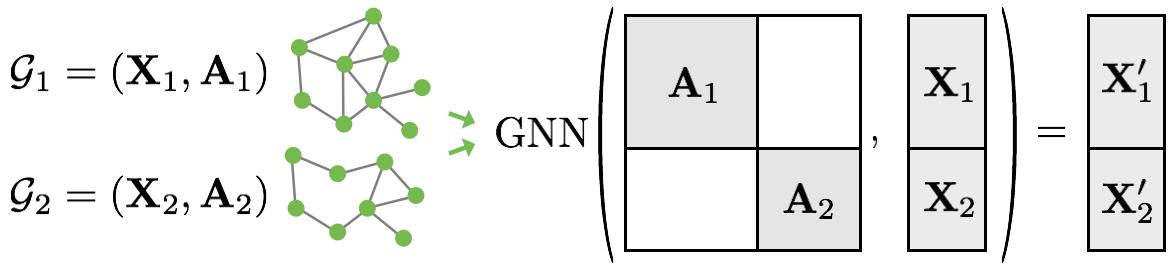

PyTorch Geometric automatically takes care of this concatenation process (**batching multiple graphs into a single giant graph**) with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

In [ ]:
from torch_geometric.loader import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2466], x=[1122, 7], edge_attr=[2466, 4], y=[64], batch=[1122], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1138, 7], edge_attr=[2506, 4], y=[64], batch=[1138], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 912], x=[410, 7], edge_attr=[912, 4], y=[22], batch=[410], ptr=[23])



We chose a `batch_size` of 32, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ graphs.

Furthermore, each batched graph object is equipped with a **batch vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$


**Architecture:**

We will create a GCN model structure that contains two **GCNConv** layers **relu** activation and a **dropout** rate of 0.5. The model consists of 32 hidden channels. The model learns to classify graphs using three main steps:


1.   Embed nodes using several rounds of **message passing**.
2.   Aggregate these node embeddings into a single graph embedding (called **readout layer**). In the code below, the average of node embeddings is used (**global mean pool**).
3.   Train a classifier based on graph embeddings.

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.


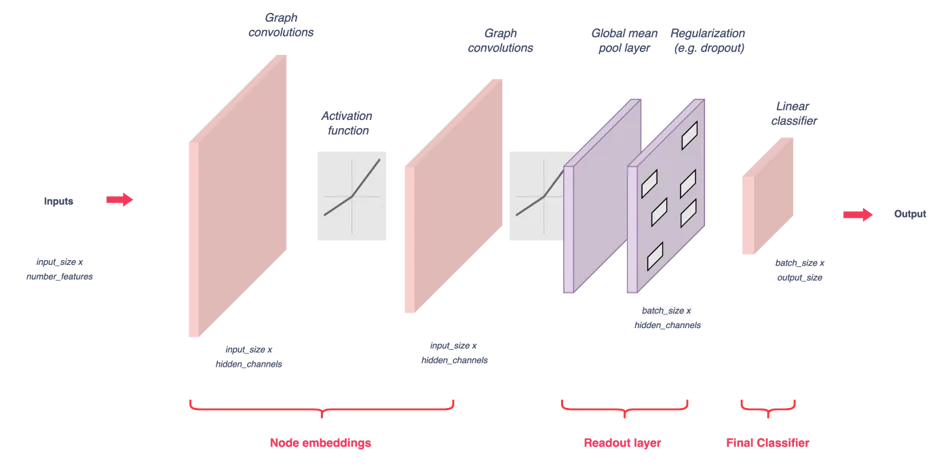

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

# Define a 2-layer GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### 2.5. Training GNN
We will train our model on 100 Epochs using **Adam** optimization and the **Cross-Entropy Loss** function.

**In the train function**, we have:
1.   Clear the gradient.
2.   Performed a single forward pass.
3.   Compute loss using training nodes.
4.   Calculate gradient, and update the parameters.


**In the test function**, we have:
1.   Predicted node class.
2.   Extracted class label with the highest probability.
3.   Checked how many values have been predicted correctly.
4.   Creating accuracy ratio using a sum of correct predictions divided by a total number of nodes.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train and test functions
def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# Train the model
for epoch in range(1, 101):
    train()
    acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Test Accuracy: {acc:.4f}')

Epoch: 001, Test Accuracy: 0.6579
Epoch: 002, Test Accuracy: 0.6579
Epoch: 003, Test Accuracy: 0.6579
Epoch: 004, Test Accuracy: 0.6579
Epoch: 005, Test Accuracy: 0.6579
Epoch: 006, Test Accuracy: 0.6579
Epoch: 007, Test Accuracy: 0.6579
Epoch: 008, Test Accuracy: 0.6579
Epoch: 009, Test Accuracy: 0.7632
Epoch: 010, Test Accuracy: 0.7105
Epoch: 011, Test Accuracy: 0.7895
Epoch: 012, Test Accuracy: 0.7632
Epoch: 013, Test Accuracy: 0.7368
Epoch: 014, Test Accuracy: 0.7632
Epoch: 015, Test Accuracy: 0.7368
Epoch: 016, Test Accuracy: 0.7105
Epoch: 017, Test Accuracy: 0.7368
Epoch: 018, Test Accuracy: 0.7632
Epoch: 019, Test Accuracy: 0.7632
Epoch: 020, Test Accuracy: 0.7368
Epoch: 021, Test Accuracy: 0.7632
Epoch: 022, Test Accuracy: 0.7632
Epoch: 023, Test Accuracy: 0.7368
Epoch: 024, Test Accuracy: 0.7632
Epoch: 025, Test Accuracy: 0.7368
Epoch: 026, Test Accuracy: 0.7632
Epoch: 027, Test Accuracy: 0.7632
Epoch: 028, Test Accuracy: 0.7632
Epoch: 029, Test Accuracy: 0.7368
Epoch: 030, Te

Our model reaches around **76% test accuracy**. Reasons for the fluctations in accuracy can be explained by the rather small dataset (only 38 test graphs).

## 3. Phase 2 – Graph Classification on Tree-Structured Graphs

### 3.1. Attempted Real Dataset (ENZYMES)


In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

# Check if the first 10 graphs are trees
for i in range(10):
    data = dataset[i]
    G = to_networkx(data, to_undirected=True)
    print(f"Graph {i} is a tree? {nx.is_tree(G)}")


Graph 0 is a tree? False
Graph 1 is a tree? False
Graph 2 is a tree? False
Graph 3 is a tree? False
Graph 4 is a tree? False
Graph 5 is a tree? False
Graph 6 is a tree? False
Graph 7 is a tree? False
Graph 8 is a tree? False
Graph 9 is a tree? False


We iterate through all graphs in the ENZYMES dataset and retain only those which satisfy the structural properties of a tree:

*   The graph is **connected**.
*   The number of **edges equals (nodes - 1)**.

Only those graphs satisfying both conditions are retained for training and testing.

In [ ]:
# To check if a graph is a tree
def is_tree(data):
    # Convert edge_index to a NetworkX graph
    G = nx.Graph()
    edge_index = data.edge_index.numpy()
    G.add_edges_from(edge_index.T)

    # Add nodes explicitly (some isolated nodes may exist)
    G.add_nodes_from(range(data.num_nodes))

    # A tree is a connected graph with (n - 1) edges
    return nx.is_connected(G) and G.number_of_edges() == G.number_of_nodes() - 1

# Filter only tree-structured graphs
tree_graphs = [data for data in dataset if is_tree(data)]

print(f"Total graphs in ENZYMES dataset: {len(dataset)}")
print(f"Number of tree-structured graphs: {len(tree_graphs)}")


Total graphs in ENZYMES dataset: 600
Number of tree-structured graphs: 2


- Filtered ENZYMES dataset to find tree-structured graphs (connected + acyclic)
- Found only 2 valid tree graphs → insufficient for training

### 3.2. Custom Dataset Generation

We will create a synthetic dataset containing 100 tree-structured graphs:  
- **Class 0**: Full binary trees  
- **Class 1**: Linear chain trees  
- **Node features**: Normalized positional indices with Gaussian noise  
- **Labels**: Binary (0 or 1)

In [ ]:
import torch
import random
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

def generate_tree_dataset(num_graphs=100):
    """
    Generate a synthetic graph dataset with tree-like structures for binary classification.
    Class 0: Balanced binary trees with varying structures.
    Class 1: Chain-like trees with varying lengths.
    Node features include positional encoding with random noise.
    """
    dataset = []
    torch.manual_seed(42)
    random.seed(42)

    for i in range(num_graphs):
        label = i % 2  # binary label

        # Class 0: Balanced binary trees with variable structure
        if label == 0:
            depth = random.choice([2, 3])  # tree depth: 2 (3 levels) or 3 (4 levels)
            num_nodes = 2**(depth + 1) - 1  # number of nodes in full binary tree
            edges = []

            for parent in range((num_nodes - 1) // 2):
                left = 2 * parent + 1
                right = 2 * parent + 2
                if left < num_nodes:
                    edges.append((parent, left))
                if right < num_nodes:
                    edges.append((parent, right))

        # Class 1: Chain (linear tree) with variable length
        else:
            num_nodes = random.randint(6, 10)
            edges = [(i, i + 1) for i in range(num_nodes - 1)]

        # Convert edge list to PyG format
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_index = to_undirected(edge_index)

        # Node features: normalized index with added noise
        base_features = torch.arange(num_nodes, dtype=torch.float).unsqueeze(1) / num_nodes
        noise = torch.randn_like(base_features) * 0.1
        x = base_features + noise

        y = torch.tensor([label], dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, y=y)
        dataset.append(data)

    return dataset


tree_dataset = generate_tree_dataset()
print(f"Total trees: {len(tree_dataset)}")
print(tree_dataset[0])

Total trees: 100
Data(x=[7, 1], edge_index=[2, 12], y=[1])


### 3.3. Split and Load the Tree Dataset

In [ ]:
import random

# Shuffle and split
random.shuffle(tree_dataset)
train_dataset = tree_dataset[:80]
test_dataset = tree_dataset[80:]

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 3.4. GCN Model Modification for Tree Data

In the original version of the model, the first GCN layer expected input node features with a higher dimensionality (e.g., a one-hot vector of size 7 for a fixed-size tree). However, in our current dataset generation strategy, each node is instead described by a **single scalar feature** — its normalized position (i.e., node index divided by the total number of nodes). This results in a node feature matrix of shape `[num_nodes, 1]`.

Due to this mismatch, the model encountered a matrix multiplication error during training. To resolve this, we modify the first `GCNConv` layer to accept a **single input channel** or one input feature per node (`in_channels=1`). This ensures compatibility between the input feature shape and the model's architecture.

This adjustment aligns the model structure with our dataset design and allows successful training and evaluation of tree-structured graph data.










In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(1, hidden_channels)   # in_channels = 1
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 2)  # Binary classification

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        return self.lin(x)

In [ ]:
model = GCN(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### 3.5. Train and Evaluation
- **Epochs**: 100  
- **Batch Size**: 32  
- **Optimizer**: Adam (lr=0.01)  
- **Loss**: CrossEntropy  

The model is trained on tree-structured graphs only.

In [ ]:
# Training loop
for epoch in range(1, 101):
    train()
    acc = test(test_loader)
    print(f'[Tree-GCN] Epoch: {epoch:03d}, Test Accuracy: {acc:.4f}')

[Tree-GCN] Epoch: 001, Test Accuracy: 0.6000
[Tree-GCN] Epoch: 002, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 003, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 004, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 005, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 006, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 007, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 008, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 009, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 010, Test Accuracy: 0.4000
[Tree-GCN] Epoch: 011, Test Accuracy: 0.5000
[Tree-GCN] Epoch: 012, Test Accuracy: 0.6500
[Tree-GCN] Epoch: 013, Test Accuracy: 0.6500
[Tree-GCN] Epoch: 014, Test Accuracy: 0.6500
[Tree-GCN] Epoch: 015, Test Accuracy: 0.6500
[Tree-GCN] Epoch: 016, Test Accuracy: 0.7000
[Tree-GCN] Epoch: 017, Test Accuracy: 0.7000
[Tree-GCN] Epoch: 018, Test Accuracy: 0.7000
[Tree-GCN] Epoch: 019, Test Accuracy: 0.7500
[Tree-GCN] Epoch: 020, Test Accuracy: 0.8500
[Tree-GCN] Epoch: 021, Test Accuracy: 0.8500
[Tree-GCN] Epoch: 022, Test Accuracy: 0.8500
[Tree-GCN]

Final test accuracy reached approximately 90% and confirm the feasibility of adapting GCNs for this type of structured data,.